In [1]:
import numpy as np
import matplotlib.pyplot as plt

from GmGM import GmGM
from GmGM.synthetic import PrecMatGenerator, DatasetGenerator
from GmGM.synthetic import PrecMatErdosRenyiGilbert
from GmGM.synthetic import measure_prec_recall, plot_prec_recall

Note: I think in this notebook, precision/recall have been flipped...  Keep that in mind while reading!  Am working on a fix.

## Main Takeaways

TODO: This section

Ignore the tests with n_comps, I am unsatisfied with the method of generating relevant graphs.

# Basic Experiments

## Experiment One
Synthetic multi-omics dataset, where true graphs are sparse.

We see that when we only have one sample (common real-world case), it's better to use col-weighted rowwise thresholding.  However, if we have a few samples (here `num_samples=10`), overall thresholding does better.

We also see that shared axes ("cell" here) get better results.

In [2]:
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "cell": 200,
        "gene": 200,
        "peak": 200
    },
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 200
	gene: 200
	peak: 200
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
axis_join=
	Kronecker Sum
distribution=
	rna: <Normal Distribution>
	atac: <Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


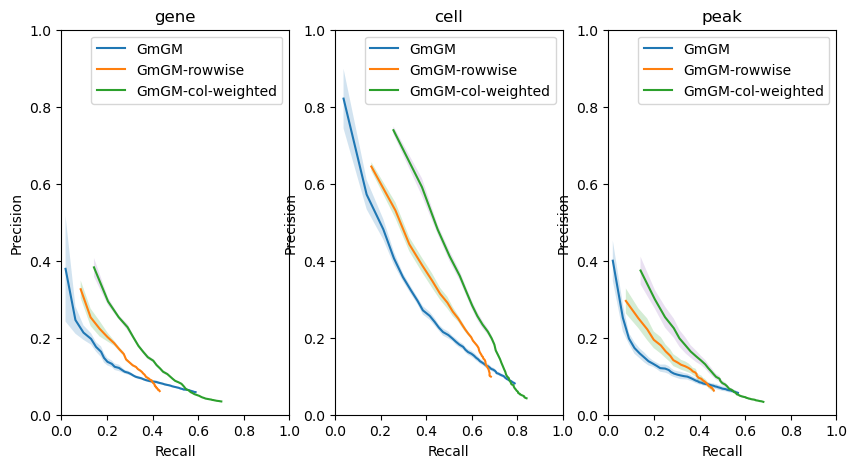

In [3]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


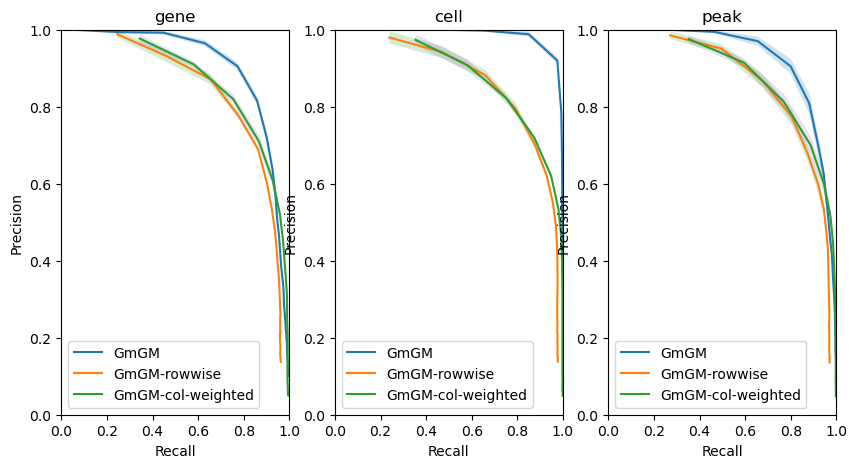

In [4]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Two

When is the principal components approximation okay?

On synthetic data I am not able to make it look okay!  I know from experiments that this approximation is able to work on real data, so more work needs to be done on figuring out why it does not work on synthetic data.

In [5]:
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
    },
    size={
        "cell": 200,
        "gene": 200,
        "peak": 200
    },
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 200
	gene: 200
	peak: 200
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
axis_join=
	Kronecker Sum
distribution=
	rna: <Normal Distribution>
	atac: <Normal Distribution>
>

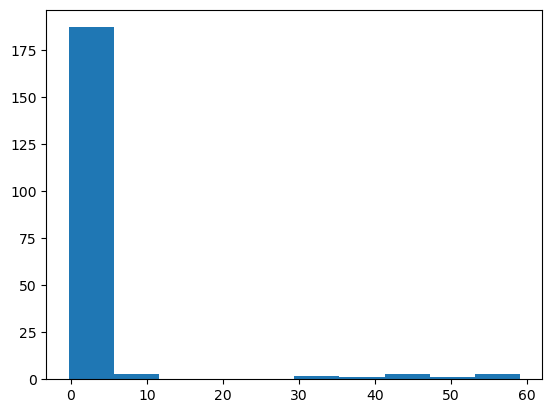

In [6]:
generator.generate()
plt.hist(np.linalg.eigh(generator.Psis["cell"])[0])
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


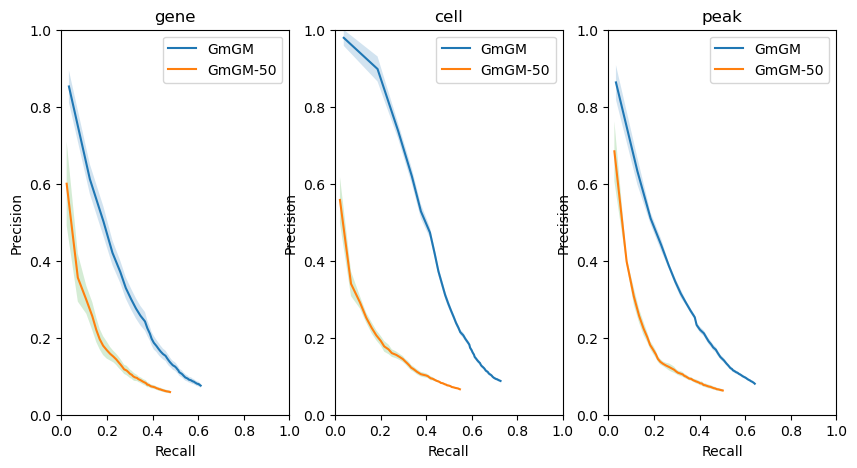

In [7]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=50),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-50": np.linspace(0.001, 0.2, 50)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


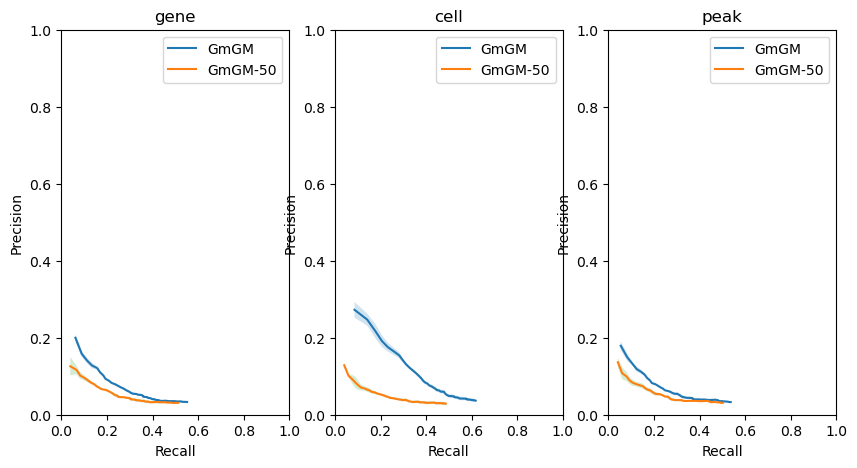

In [8]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", n_comps=50),
    },
    Lambdas={
        "GmGM": np.arange(1, 51),
        "GmGM-50": np.arange(1, 51),
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


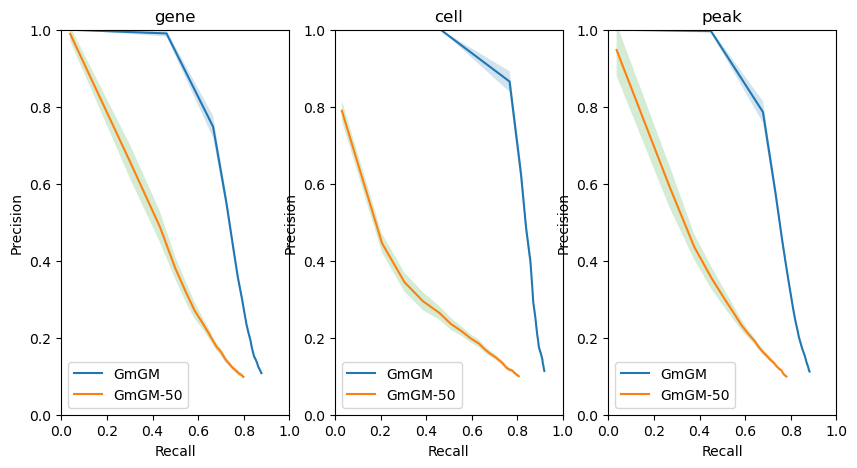

In [10]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=50),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 20),
        "GmGM-50": np.linspace(0.001, 0.2, 20),
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


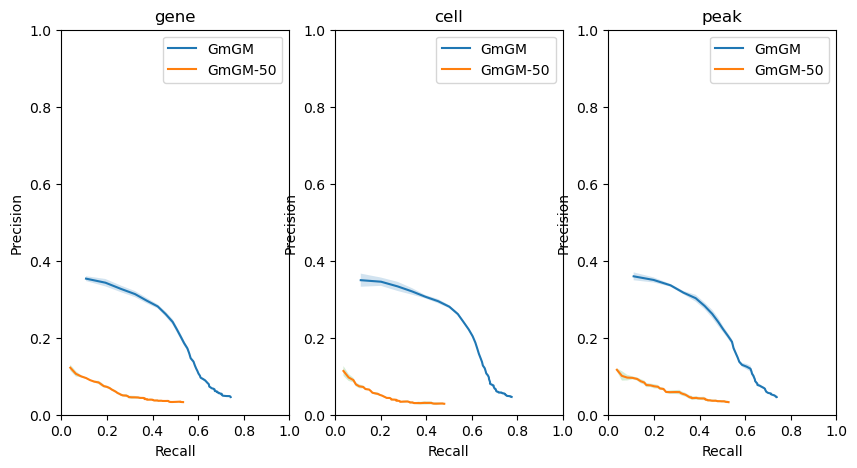

In [11]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", n_comps=50),
    },
    Lambdas={
        "GmGM": np.arange(1, 51),
        "GmGM-50": np.arange(1, 51),
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Three: Tensor Data

Best to do "overall" thresholding, and we get near-perfect performance with only one sample.  This makes sense as in tensor data, we have "many more" samples (an AxBxC tensor has BC data points for each element along the A axis, compared to an AxB matrix which only has B data points).

In [12]:
generator = DatasetGenerator(
    structure={
        "tensor": ("A", "B", "C"),
    },
    generator={
        "A": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "B": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "C": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "A": 50,
        "B": 50,
        "C": 50
    },
)
generator

<DatasetGenerator, structure=
	tensor: ('', 'A', 'B', 'C')
size=
	A: 50
	B: 50
	C: 50
generator=
	A: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	B: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	C: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
axis_join=
	Kronecker Sum
distribution=
	tensor: <Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


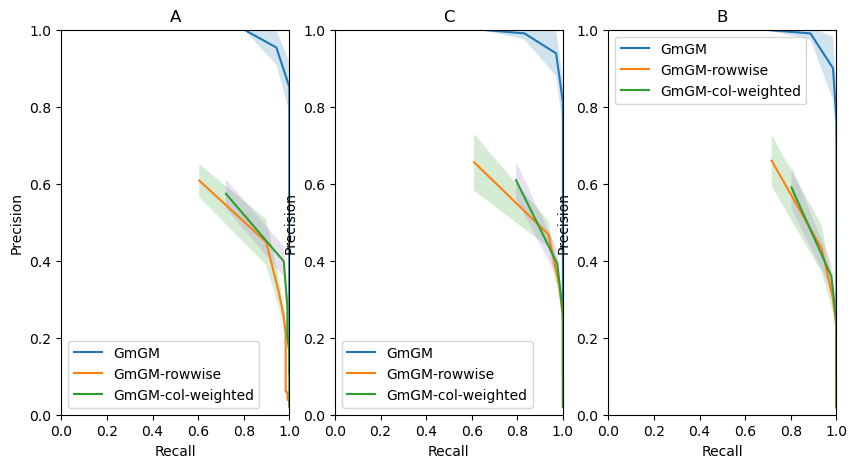

In [13]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


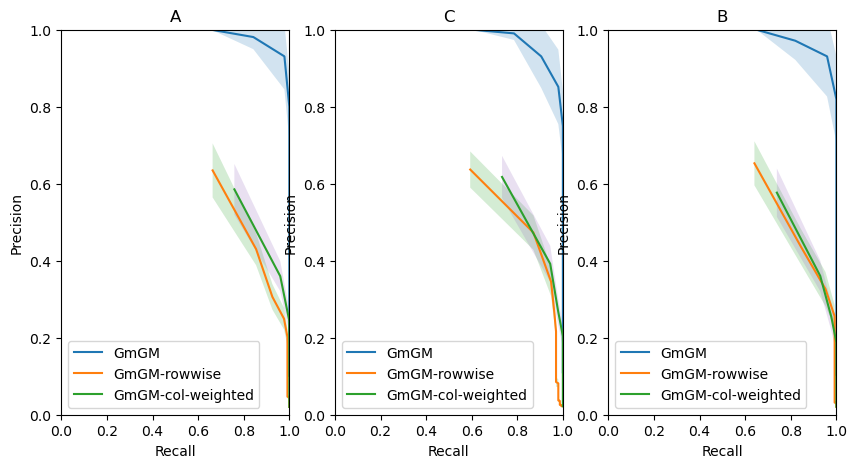

In [14]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Four: Tensor Data, n_comps << size

In [19]:
generator = DatasetGenerator(
    structure={
        "tensor": ("A", "B", "C"),
    },
    generator={
        "A": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "B": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "C": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
    },
    size={
        "A": 50,
        "B": 50,
        "C": 50
    },
)
generator

<DatasetGenerator, structure=
	tensor: ('', 'A', 'B', 'C')
size=
	A: 50
	B: 50
	C: 50
generator=
	A: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	B: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	C: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
axis_join=
	Kronecker Sum
distribution=
	tensor: <Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


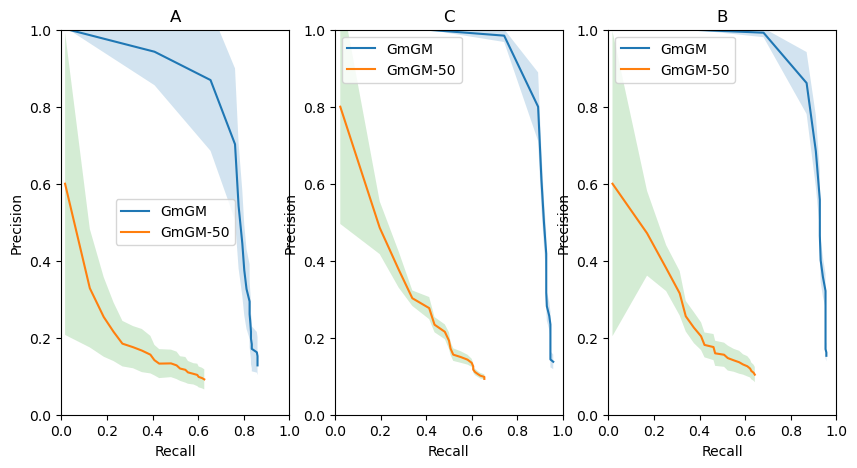

In [20]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=20),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 20),
        "GmGM-50": np.linspace(0.001, 0.2, 20),
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


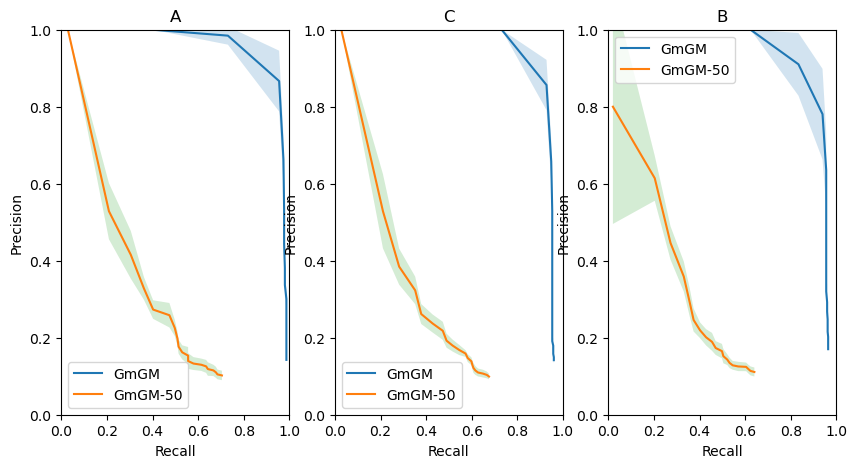

In [21]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=20),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 20),
        "GmGM-50": np.linspace(0.001, 0.2, 20),
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Five: Non-normal data

The col-weighting method is the only one that works on non-normal data, it seems.

In [22]:
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "cell": 200,
        "gene": 200,
        "peak": 200
    },
    distribution="Log Normal"
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 200
	gene: 200
	peak: 200
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
axis_join=
	Kronecker Sum
distribution=
	rna: <Log Normal Distribution>
	atac: <Log Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


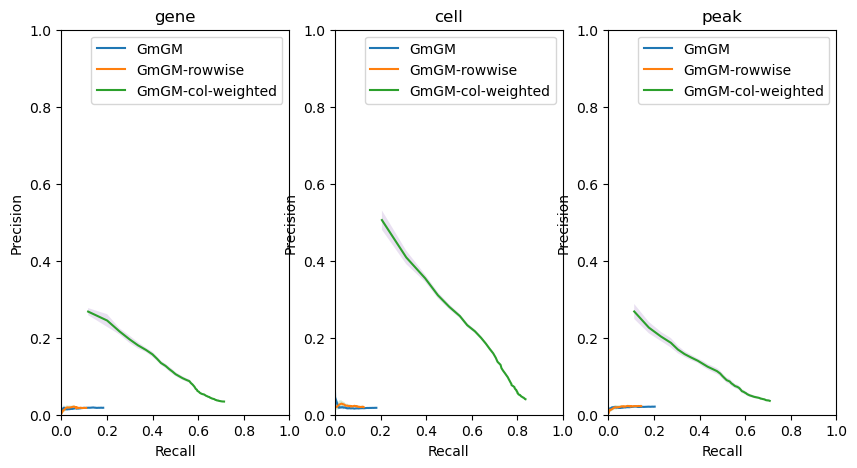

In [23]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


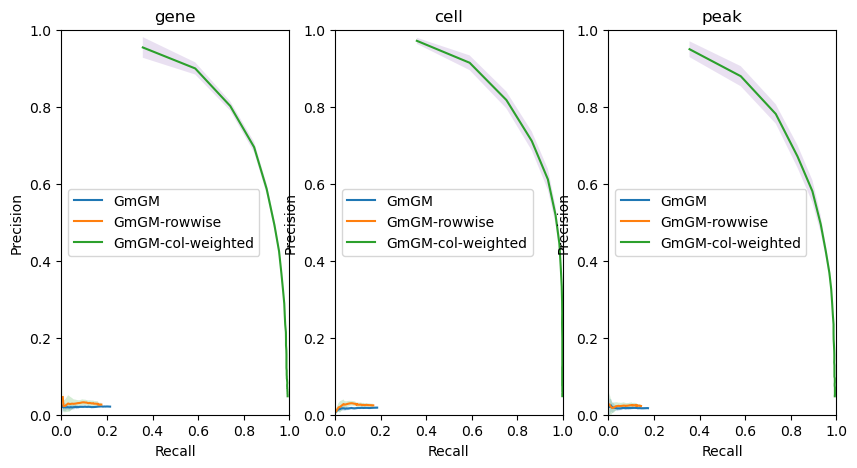

In [24]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Six: Non-normal data, n_comps << size

**On non-normal data, the pricipal components approximation seems to do better than without it!!** (At least in some regimes)

In [25]:
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
    },
    size={
        "cell": 200,
        "gene": 200,
        "peak": 200
    },
    distribution="Log Normal"
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 200
	gene: 200
	peak: 200
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
axis_join=
	Kronecker Sum
distribution=
	rna: <Log Normal Distribution>
	atac: <Log Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


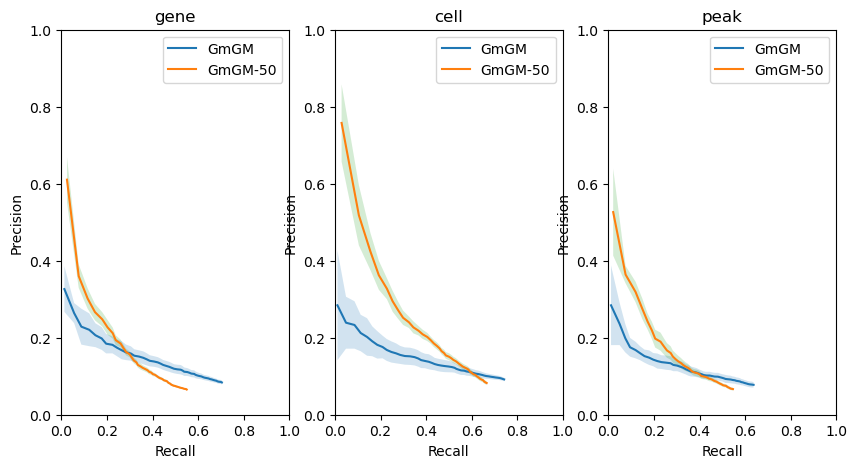

In [26]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=50),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-50": np.linspace(0.001, 0.2, 50)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


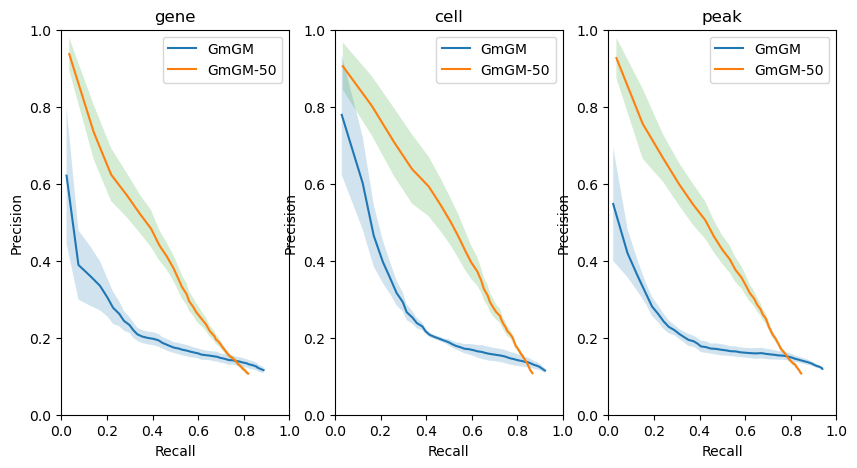

In [27]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=50),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-50": np.linspace(0.001, 0.2, 50)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Seven: Non-normal tensor data

In [28]:
generator = DatasetGenerator(
    structure={
        "tensor": ("A", "B", "C"),
    },
    generator={
        "A": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "B": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "C": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
    },
    size={
        "A": 50,
        "B": 50,
        "C": 50
    },
    distribution="Log Normal"
)
generator

<DatasetGenerator, structure=
	tensor: ('', 'A', 'B', 'C')
size=
	A: 50
	B: 50
	C: 50
generator=
	A: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	B: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	C: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
axis_join=
	Kronecker Sum
distribution=
	tensor: <Log Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


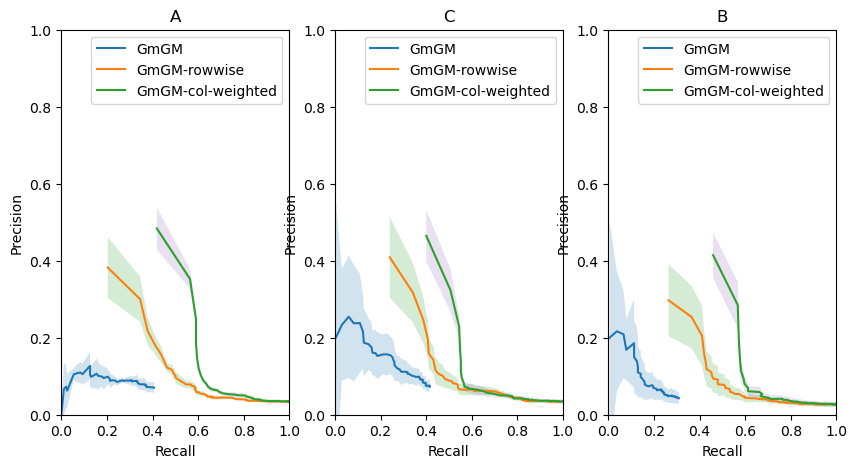

In [29]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


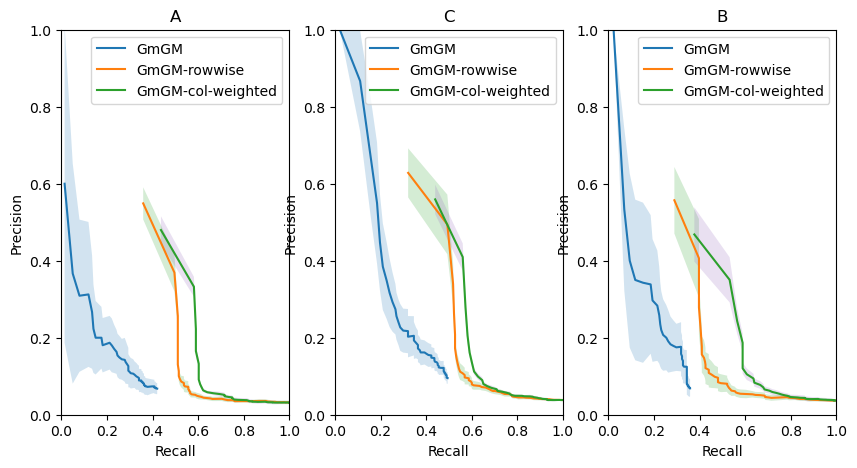

In [30]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


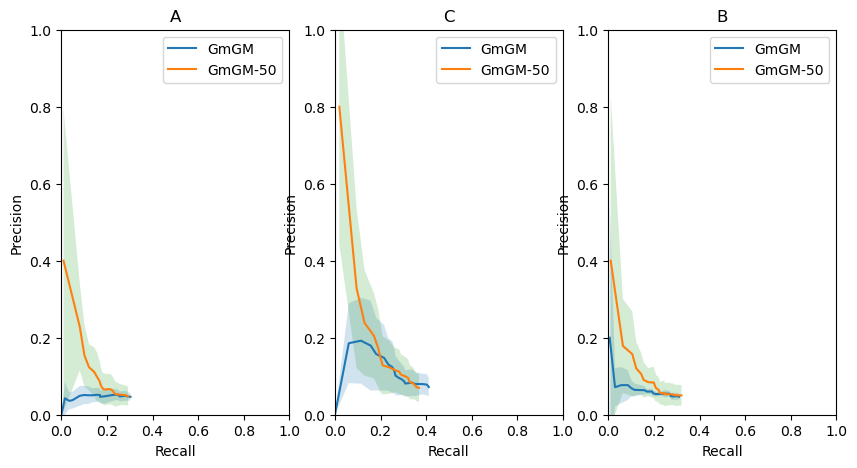

In [31]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=20),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 20),
        "GmGM-50": np.linspace(0.001, 0.2, 20),
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


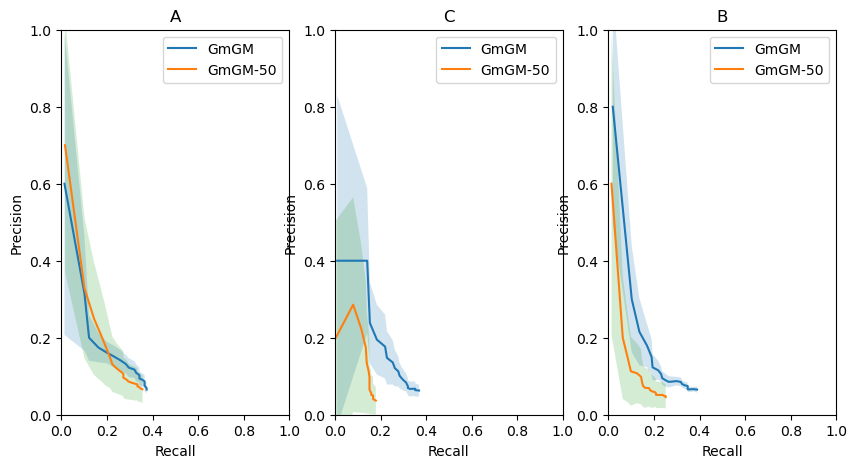

In [32]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=20),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 20),
        "GmGM-50": np.linspace(0.001, 0.2, 20),
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Eight: Zero-Inflated

In [33]:
from GmGM.synthetic import ZiLNDistribution
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "cell": 200,
        "gene": 200,
        "peak": 200
    },
    distribution=ZiLNDistribution(np.random.uniform(size=(200)).reshape(1, 200))
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 200
	gene: 200
	peak: 200
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
axis_join=
	Kronecker Sum
distribution=
	rna: <ZiLN Distribution, truncation=[[0.61431116 0.04184074 0.87013215 0.72456996 0.21468474 0.65455584
  0.30738348 0.05881067 0.14774824 0.10206223 0.02777325 0.50850767
  0.94613319 0.2328189  0.83944678 0.12978569 0.80245871 0.43039001
  0.60434117 0.87838256 0.35737822 0.64203079 0.98440735 0.95428098
  0.00300279 0.07631079 0.96422898 0.35582529 0.21468151 0.74237701
  0.10600864 0.29701083 0.37373012 0.18671479 0.3285091  0.85198097
  0.3169638  0.48427444 0.05656598 0.80882845 0.95840699 0.74266591
  0.16394383 0.39555542 0.6

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


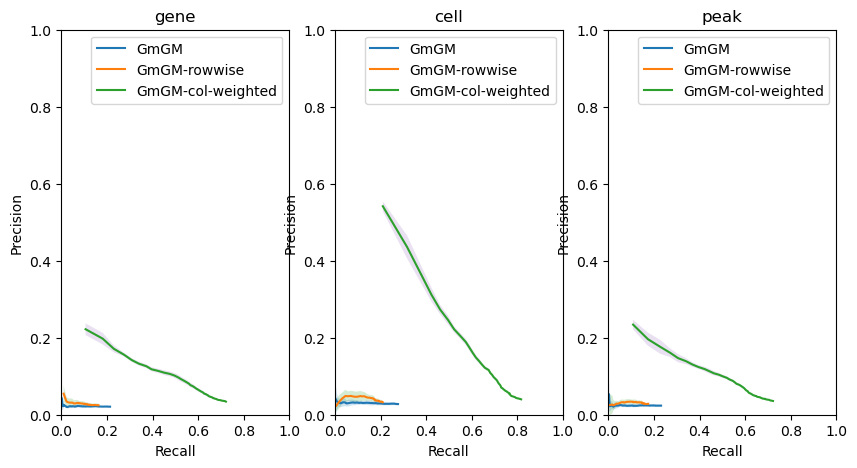

In [34]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


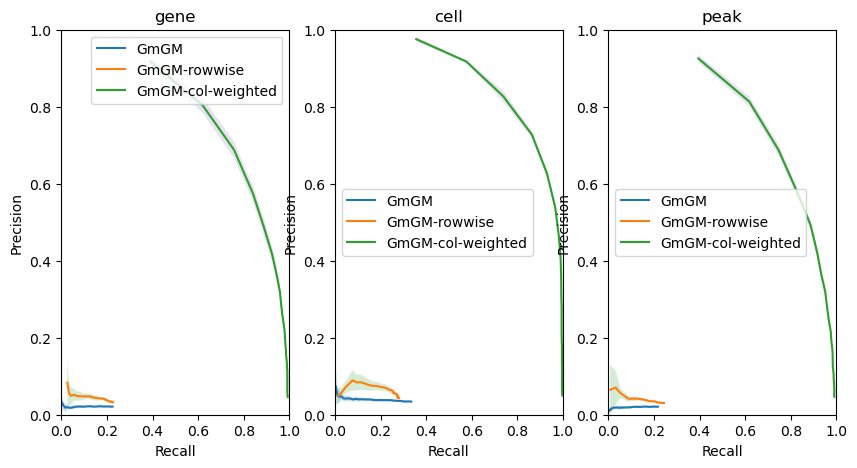

In [36]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


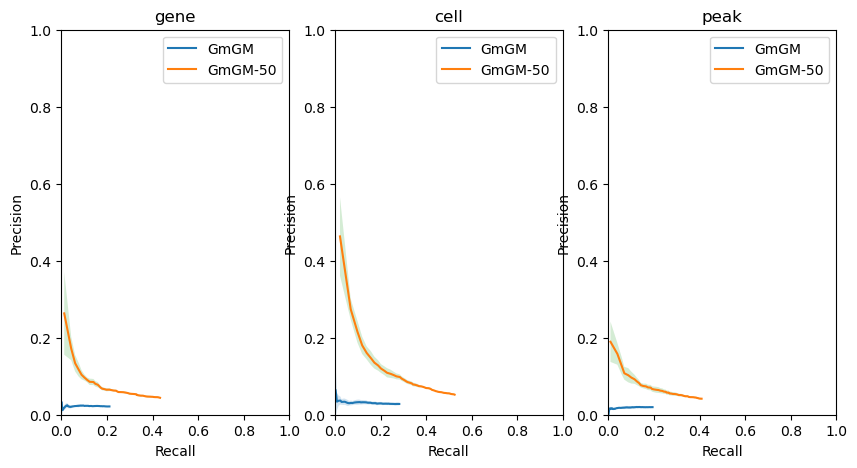

In [37]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=50),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-50": np.linspace(0.001, 0.2, 50)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


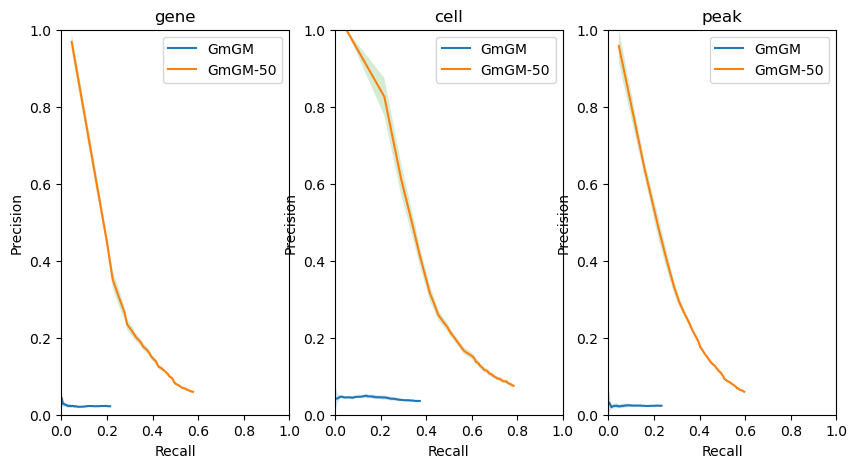

In [39]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=50),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-50": np.linspace(0.001, 0.2, 50)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


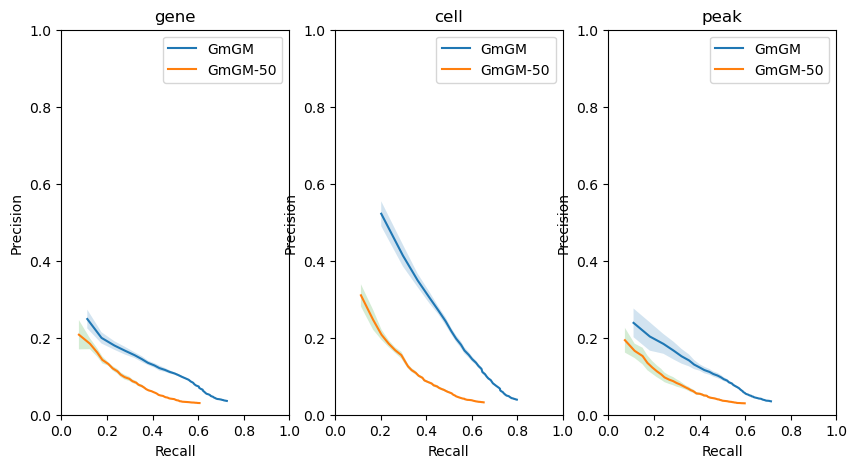

In [40]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", n_comps=50),
    },
    Lambdas={
        "GmGM": np.arange(1, 51),
        "GmGM-50": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


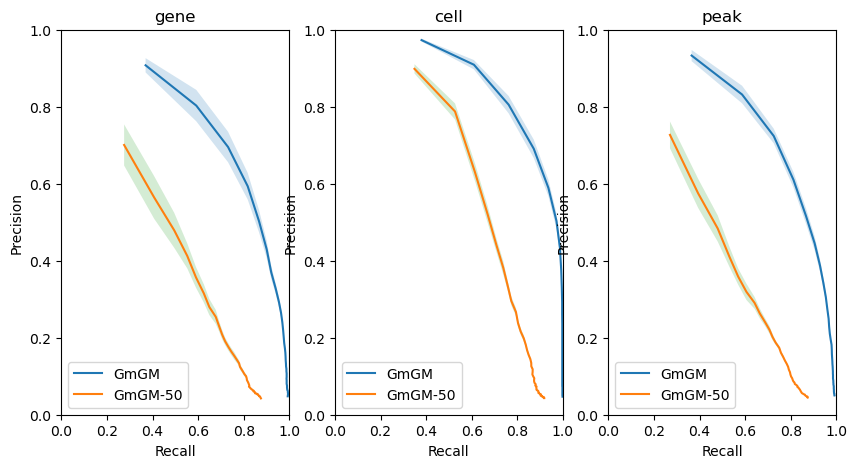

In [41]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", n_comps=50),
    },
    Lambdas={
        "GmGM": np.arange(1, 51),
        "GmGM-50": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Nine: Zero-Inflated, Low n_comps

In [42]:
from GmGM.synthetic import ZiLNDistribution
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
    },
    size={
        "cell": 200,
        "gene": 200,
        "peak": 200
    },
    distribution=ZiLNDistribution(np.random.uniform(size=(200)).reshape(1, 200))
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 200
	gene: 200
	peak: 200
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
axis_join=
	Kronecker Sum
distribution=
	rna: <ZiLN Distribution, truncation=[[0.72219593 0.24074955 0.29279472 0.4188255  0.46725896 0.76177679
  0.02928692 0.61487807 0.12103001 0.94701979 0.7217727  0.71757874
  0.20073818 0.51076611 0.35865173 0.2056497  0.06074712 0.18845125
  0.985042   0.67334715 0.88387734 0.68142716 0.82656662 0.27977692
  0.71581393 0.87873627 0.20045586 0.49492046 0.22802539 0.65799461
  0.01308202 0.77480954 0.92803845 0.55663646 0.34583654 0.76696036
  0.84757181 0.65856423 0.11753784 0.30964184 0.48833708 0.

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


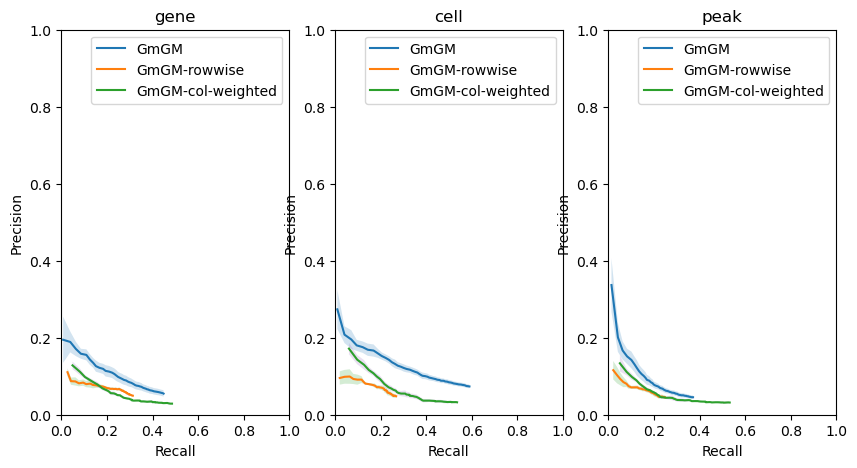

In [43]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


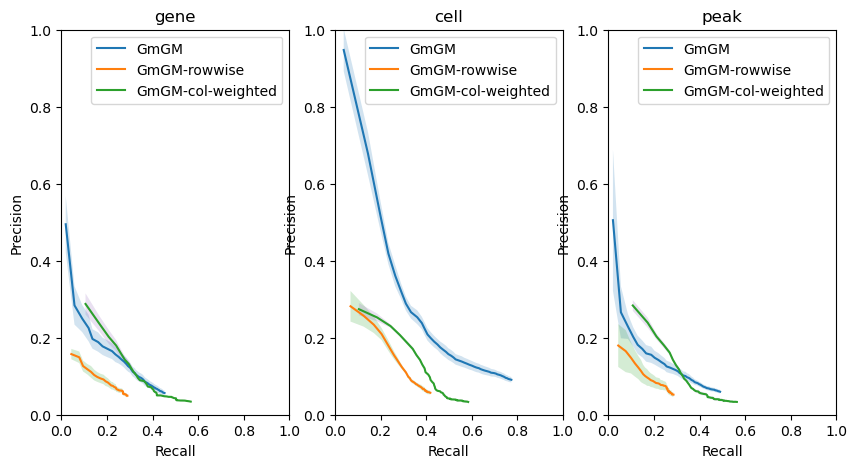

In [44]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


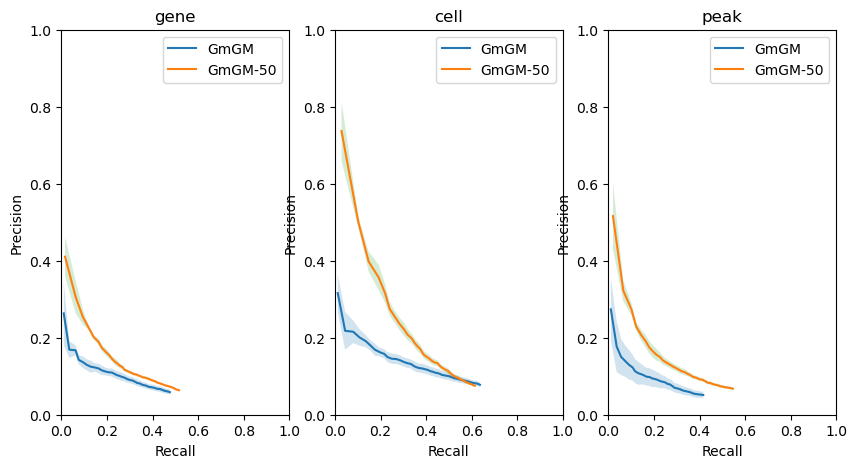

In [45]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=50),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-50": np.linspace(0.001, 0.2, 50)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


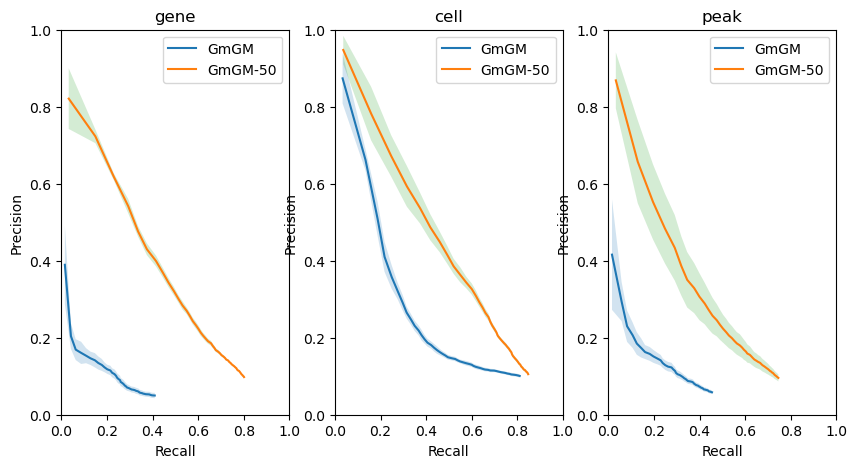

In [46]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=50),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-50": np.linspace(0.001, 0.2, 50)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


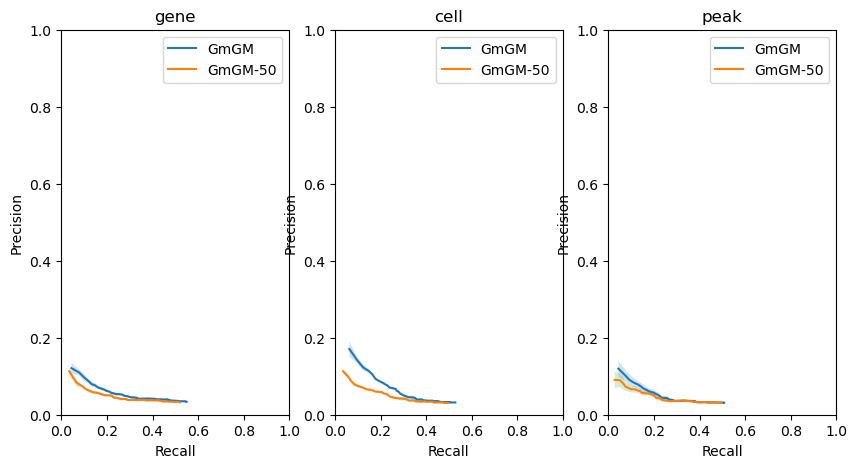

In [47]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", n_comps=50),
    },
    Lambdas={
        "GmGM": np.arange(1, 51),
        "GmGM-50": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


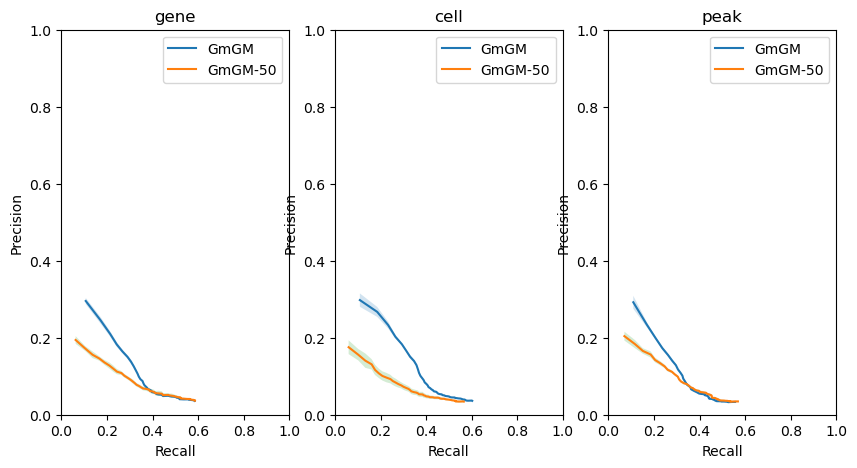

In [48]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", n_comps=50),
    },
    Lambdas={
        "GmGM": np.arange(1, 51),
        "GmGM-50": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

# Nonparanormal Experiments

## Experiment Ten: Normal; Nonparanormal Skeptic

In [2]:
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "cell": 50,
        "gene": 50,
        "peak": 50
    },
    distribution="Normal"
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 50
	gene: 50
	peak: 50
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
axis_join=
	Kronecker Sum
distribution=
	rna: <Normal Distribution>
	atac: <Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


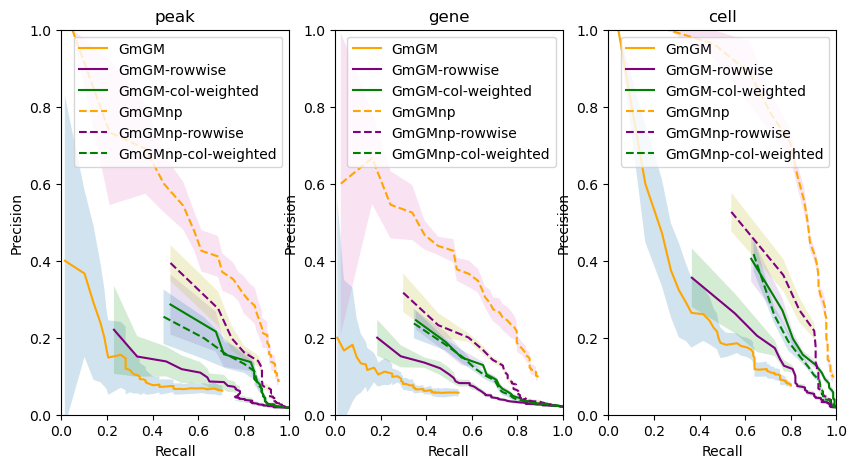

In [12]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
        "GmGMnp-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise", use_nonparanormal_skeptic=True),
        "GmGMnp-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", use_nonparanormal_skeptic=True)
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51),
        "GmGMnp": np.linspace(0.001, 0.2, 50),
        "GmGMnp-rowwise": np.arange(1, 51),
        "GmGMnp-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGM-rowwise": "purple",
        "GmGM-col-weighted": "green",
        "GmGMnp": "orange",
        "GmGMnp-rowwise": "purple",
        "GmGMnp-col-weighted": "green"
    },
    linestyle={
        "GmGM": "-",
        "GmGM-rowwise": "-",
        "GmGM-col-weighted": "-",
        "GmGMnp": "--",
        "GmGMnp-rowwise": "--",
        "GmGMnp-col-weighted": "--"
    }
)
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


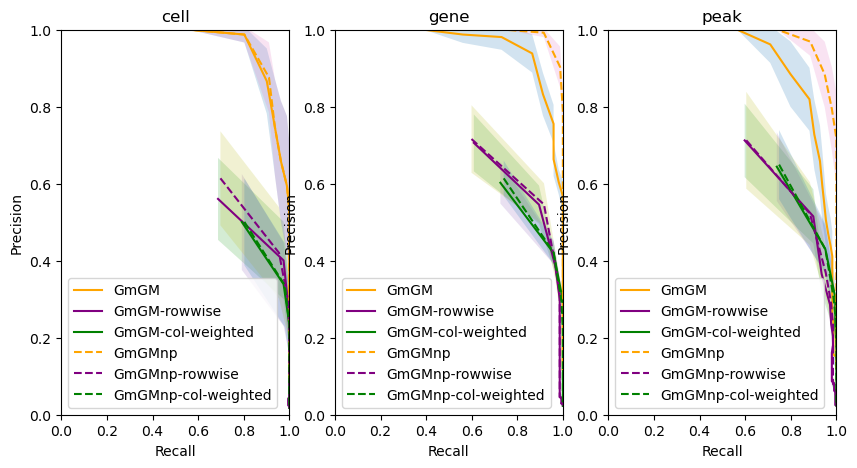

In [3]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
        "GmGMnp-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise", use_nonparanormal_skeptic=True),
        "GmGMnp-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", use_nonparanormal_skeptic=True)
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51),
        "GmGMnp": np.linspace(0.001, 0.2, 50),
        "GmGMnp-rowwise": np.arange(1, 51),
        "GmGMnp-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGM-rowwise": "purple",
        "GmGM-col-weighted": "green",
        "GmGMnp": "orange",
        "GmGMnp-rowwise": "purple",
        "GmGMnp-col-weighted": "green"
    },
    linestyle={
        "GmGM": "-",
        "GmGM-rowwise": "-",
        "GmGM-col-weighted": "-",
        "GmGMnp": "--",
        "GmGMnp-rowwise": "--",
        "GmGMnp-col-weighted": "--"
    }
)
pass

## Experiment Eleven: Nonpara, nonnormal

In [5]:
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "cell": 50,
        "gene": 50,
        "peak": 50
    },
    distribution="Log Normal"
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 50
	gene: 50
	peak: 50
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
axis_join=
	Kronecker Sum
distribution=
	rna: <Log Normal Distribution>
	atac: <Log Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


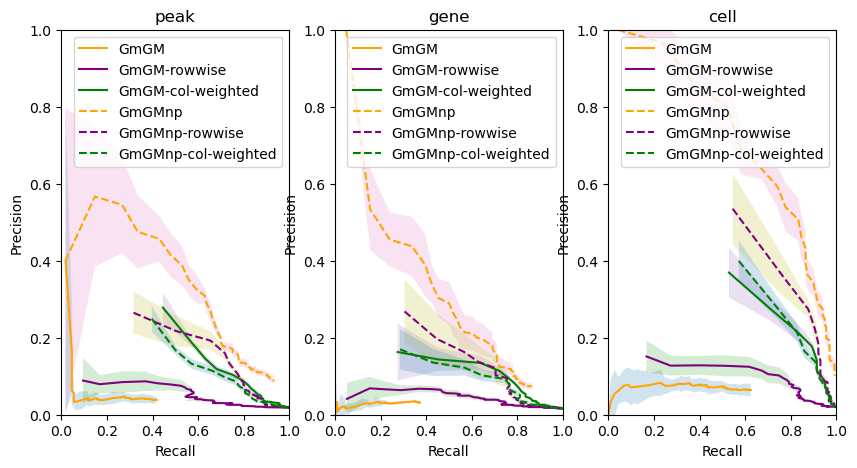

In [6]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
        "GmGMnp-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise", use_nonparanormal_skeptic=True),
        "GmGMnp-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", use_nonparanormal_skeptic=True)
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51),
        "GmGMnp": np.linspace(0.001, 0.2, 50),
        "GmGMnp-rowwise": np.arange(1, 51),
        "GmGMnp-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGM-rowwise": "purple",
        "GmGM-col-weighted": "green",
        "GmGMnp": "orange",
        "GmGMnp-rowwise": "purple",
        "GmGMnp-col-weighted": "green"
    },
    linestyle={
        "GmGM": "-",
        "GmGM-rowwise": "-",
        "GmGM-col-weighted": "-",
        "GmGMnp": "--",
        "GmGMnp-rowwise": "--",
        "GmGMnp-col-weighted": "--"
    }
)
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


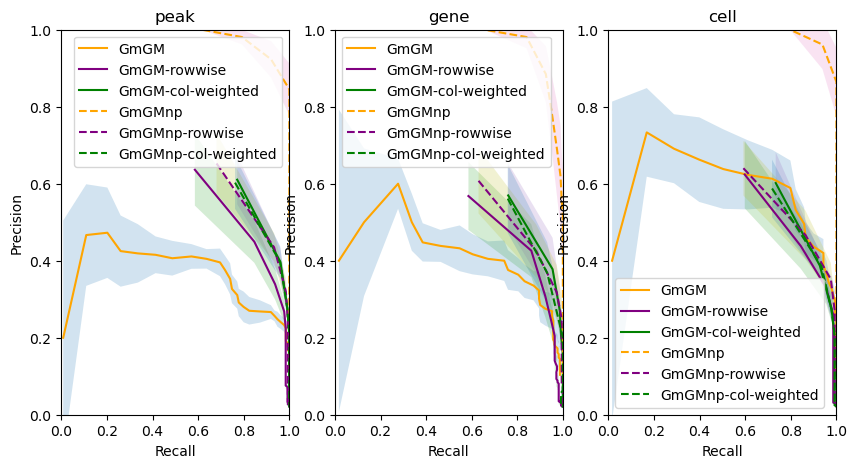

In [7]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
        "GmGMnp-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise", use_nonparanormal_skeptic=True),
        "GmGMnp-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", use_nonparanormal_skeptic=True)
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51),
        "GmGMnp": np.linspace(0.001, 0.2, 50),
        "GmGMnp-rowwise": np.arange(1, 51),
        "GmGMnp-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGM-rowwise": "purple",
        "GmGM-col-weighted": "green",
        "GmGMnp": "orange",
        "GmGMnp-rowwise": "purple",
        "GmGMnp-col-weighted": "green"
    },
    linestyle={
        "GmGM": "-",
        "GmGM-rowwise": "-",
        "GmGM-col-weighted": "-",
        "GmGMnp": "--",
        "GmGMnp-rowwise": "--",
        "GmGMnp-col-weighted": "--"
    }
)
pass

## Experiment Twelve: Nonparanormal, zero-inflated

In [8]:
from GmGM.synthetic import ZiLNDistribution
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "cell": 50,
        "gene": 50,
        "peak": 50
    },
    distribution=ZiLNDistribution(np.random.uniform(size=(50)).reshape(1, 50))
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 50
	gene: 50
	peak: 50
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
axis_join=
	Kronecker Sum
distribution=
	rna: <ZiLN Distribution, truncation=[[0.74227935 0.29357982 0.81680161 0.00842444 0.44197861 0.47785401
  0.70723007 0.75926164 0.10975353 0.43320985 0.80169761 0.23106031
  0.05930254 0.84501971 0.44888981 0.27161191 0.99848435 0.41728304
  0.5352422  0.56538925 0.76755229 0.43385425 0.56828379 0.49709516
  0.52791749 0.54691518 0.42085111 0.31858058 0.84167747 0.01870823
  0.84352941 0.82450702 0.93817    0.72045544 0.71925471 0.05391248
  0.98221994 0.4090304  0.93089991 0.97592048 0.94911852 0.05149482
  0.33194916 0.79592238 0.7226

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


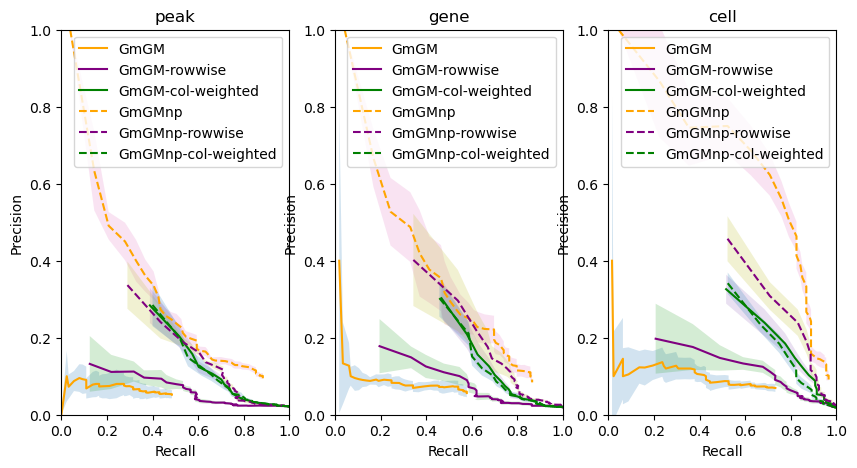

In [9]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
        "GmGMnp-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise", use_nonparanormal_skeptic=True),
        "GmGMnp-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", use_nonparanormal_skeptic=True)
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51),
        "GmGMnp": np.linspace(0.001, 0.2, 50),
        "GmGMnp-rowwise": np.arange(1, 51),
        "GmGMnp-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGM-rowwise": "purple",
        "GmGM-col-weighted": "green",
        "GmGMnp": "orange",
        "GmGMnp-rowwise": "purple",
        "GmGMnp-col-weighted": "green"
    },
    linestyle={
        "GmGM": "-",
        "GmGM-rowwise": "-",
        "GmGM-col-weighted": "-",
        "GmGMnp": "--",
        "GmGMnp-rowwise": "--",
        "GmGMnp-col-weighted": "--"
    }
)
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


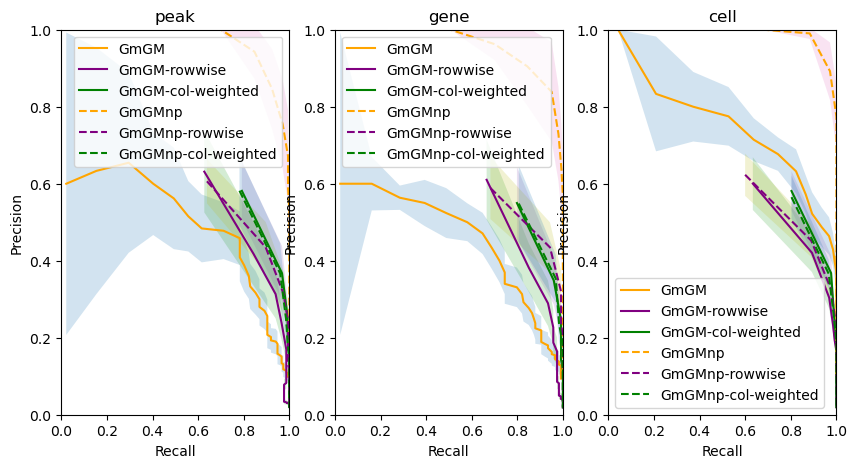

In [10]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
        "GmGMnp-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise", use_nonparanormal_skeptic=True),
        "GmGMnp-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", use_nonparanormal_skeptic=True)
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51),
        "GmGMnp": np.linspace(0.001, 0.2, 50),
        "GmGMnp-rowwise": np.arange(1, 51),
        "GmGMnp-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGM-rowwise": "purple",
        "GmGM-col-weighted": "green",
        "GmGMnp": "orange",
        "GmGMnp-rowwise": "purple",
        "GmGMnp-col-weighted": "green"
    },
    linestyle={
        "GmGM": "-",
        "GmGM-rowwise": "-",
        "GmGM-col-weighted": "-",
        "GmGMnp": "--",
        "GmGMnp-rowwise": "--",
        "GmGMnp-col-weighted": "--"
    }
)
pass

## Experiment Thirteen: Nonparanormal, Ziln-multinomial

Takeaways: `clr-prost` centering with `nonparanormal` and `overall` thresholding does best if interested in the main axis.  If interested in other axes, do terribly - but `rowwise-col-weighted` can recover some performance.  This is no surprise as the model generates the multinomial variables independently, thus making us loose the cell axis.  `rowwise-col-weighted` doing better than random is surprising.

In [11]:
from GmGM.synthetic import ZiLNMultinomial
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "cell": 50,
        "gene": 50,
        "peak": 50
    },
    distribution=ZiLNMultinomial(
        np.random.uniform(size=(50)),
        np.random.randint(1, 200, size=(50))
    )
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 50
	gene: 50
	peak: 50
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
axis_join=
	Kronecker Sum
distribution=
	rna: <ZiLN Multinomial, truncation=[0.53265901 0.96408668 0.7896671  0.57185251 0.08880198 0.82219804
 0.72968205 0.0213613  0.65175205 0.66288942 0.7343161  0.09971027
 0.30370162 0.59416482 0.91041279 0.18684978 0.16712318 0.18370918
 0.2805325  0.64569265 0.56253238 0.61875109 0.65113144 0.99731931
 0.44149953 0.09720809 0.56545175 0.507818   0.40096244 0.74790311
 0.03344537 0.10268066 0.06968427 0.91382465 0.85659217 0.86562786
 0.8059147  0.48703145 0.96787302 0.57011777 0.1661114  0.65376265
 0.34219272 0.83836966 0.47265959 0.65

Attempt 1/5


Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


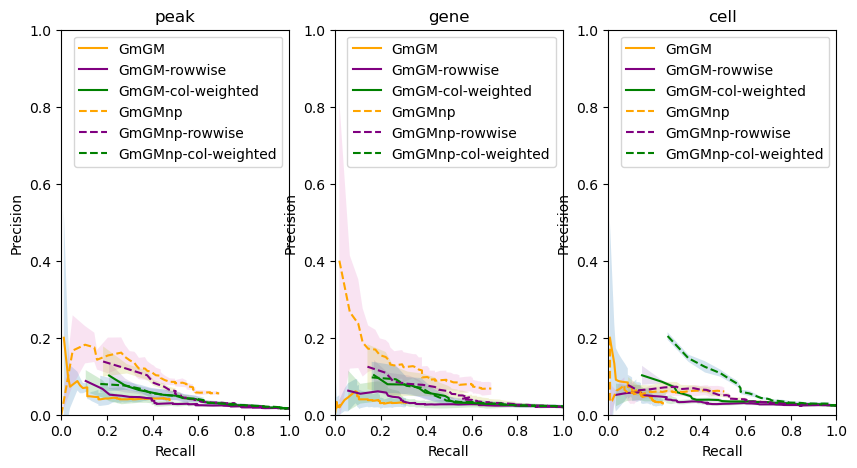

In [12]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
        "GmGMnp-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise", use_nonparanormal_skeptic=True),
        "GmGMnp-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", use_nonparanormal_skeptic=True)
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51),
        "GmGMnp": np.linspace(0.001, 0.2, 50),
        "GmGMnp-rowwise": np.arange(1, 51),
        "GmGMnp-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGM-rowwise": "purple",
        "GmGM-col-weighted": "green",
        "GmGMnp": "orange",
        "GmGMnp-rowwise": "purple",
        "GmGMnp-col-weighted": "green"
    },
    linestyle={
        "GmGM": "-",
        "GmGM-rowwise": "-",
        "GmGM-col-weighted": "-",
        "GmGMnp": "--",
        "GmGMnp-rowwise": "--",
        "GmGMnp-col-weighted": "--"
    }
)
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


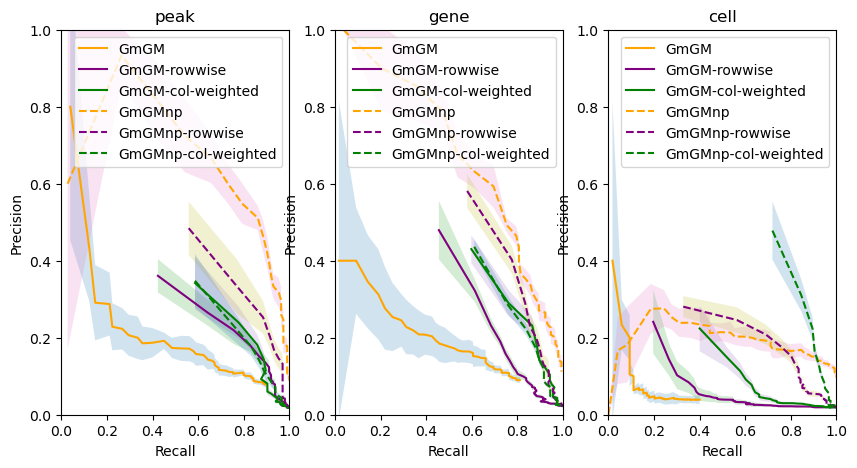

In [13]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
        "GmGMnp-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise", use_nonparanormal_skeptic=True),
        "GmGMnp-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", use_nonparanormal_skeptic=True)
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51),
        "GmGMnp": np.linspace(0.001, 0.2, 50),
        "GmGMnp-rowwise": np.arange(1, 51),
        "GmGMnp-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGM-rowwise": "purple",
        "GmGM-col-weighted": "green",
        "GmGMnp": "orange",
        "GmGMnp-rowwise": "purple",
        "GmGMnp-col-weighted": "green"
    },
    linestyle={
        "GmGM": "-",
        "GmGM-rowwise": "-",
        "GmGM-col-weighted": "-",
        "GmGMnp": "--",
        "GmGMnp-rowwise": "--",
        "GmGMnp-col-weighted": "--"
    }
)
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


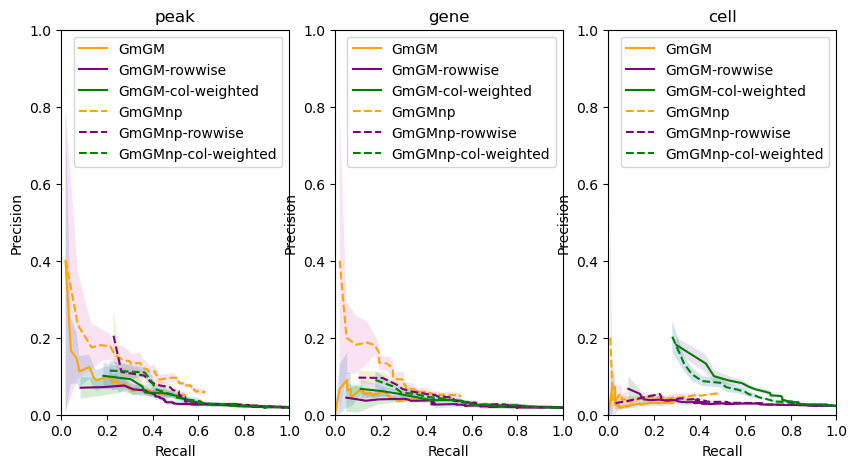

In [14]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", centering_method="clr-prost"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise", centering_method="clr-prost"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", centering_method="clr-prost"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True, centering_method="clr-prost"),
        "GmGMnp-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise", use_nonparanormal_skeptic=True, centering_method="clr-prost"),
        "GmGMnp-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", use_nonparanormal_skeptic=True, centering_method="clr-prost")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51),
        "GmGMnp": np.linspace(0.001, 0.2, 50),
        "GmGMnp-rowwise": np.arange(1, 51),
        "GmGMnp-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGM-rowwise": "purple",
        "GmGM-col-weighted": "green",
        "GmGMnp": "orange",
        "GmGMnp-rowwise": "purple",
        "GmGMnp-col-weighted": "green"
    },
    linestyle={
        "GmGM": "-",
        "GmGM-rowwise": "-",
        "GmGM-col-weighted": "-",
        "GmGMnp": "--",
        "GmGMnp-rowwise": "--",
        "GmGMnp-col-weighted": "--"
    }
)
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


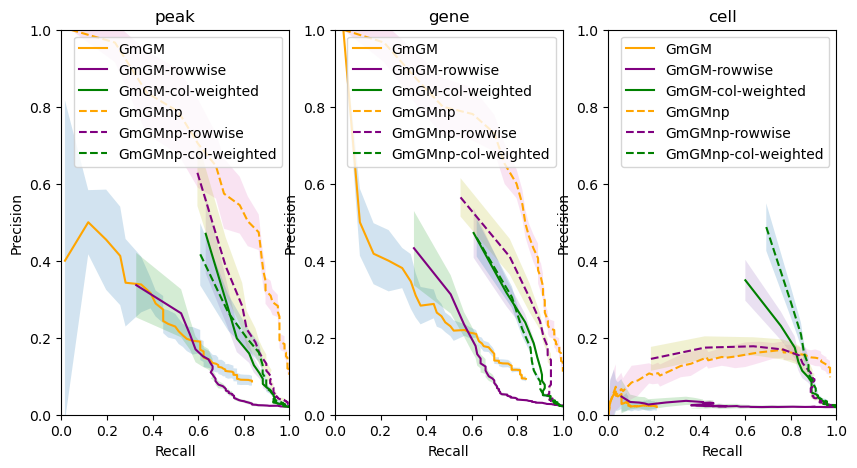

In [15]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", centering_method="clr-prost"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise", centering_method="clr-prost"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", centering_method="clr-prost"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True, centering_method="clr-prost"),
        "GmGMnp-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise", use_nonparanormal_skeptic=True, centering_method="clr-prost"),
        "GmGMnp-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", use_nonparanormal_skeptic=True, centering_method="clr-prost")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51),
        "GmGMnp": np.linspace(0.001, 0.2, 50),
        "GmGMnp-rowwise": np.arange(1, 51),
        "GmGMnp-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGM-rowwise": "purple",
        "GmGM-col-weighted": "green",
        "GmGMnp": "orange",
        "GmGMnp-rowwise": "purple",
        "GmGMnp-col-weighted": "green"
    },
    linestyle={
        "GmGM": "-",
        "GmGM-rowwise": "-",
        "GmGM-col-weighted": "-",
        "GmGMnp": "--",
        "GmGMnp-rowwise": "--",
        "GmGMnp-col-weighted": "--"
    }
)
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


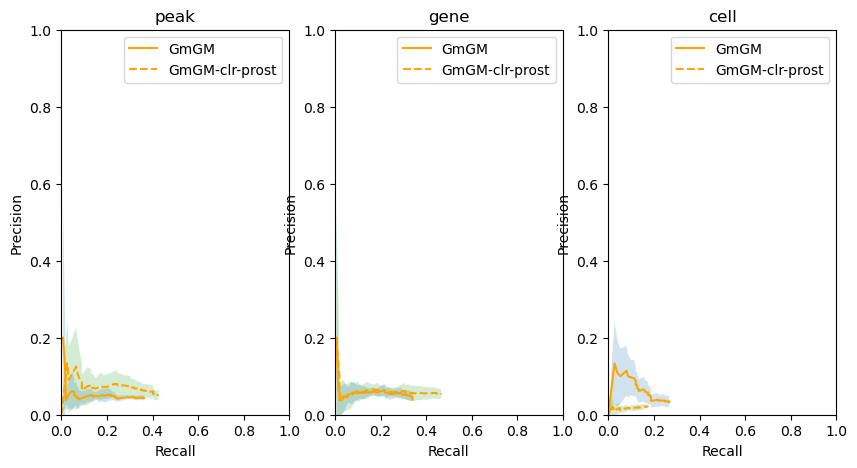

In [16]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-clr-prost": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", centering_method="clr-prost"),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-clr-prost": np.linspace(0.001, 0.2, 50),
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGM-clr-prost": "orange",
    },
    linestyle={
        "GmGM": "-",
        "GmGM-clr-prost": "--",
    }
)
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


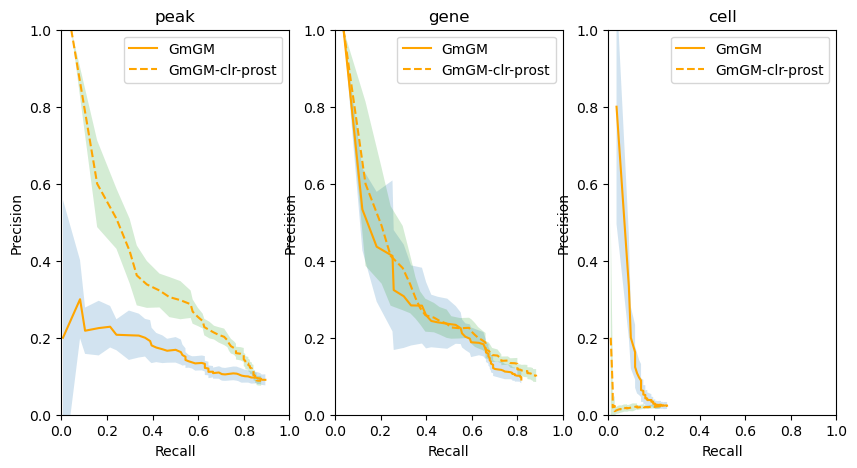

In [17]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-clr-prost": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", centering_method="clr-prost"),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-clr-prost": np.linspace(0.001, 0.2, 50),
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGM-clr-prost": "orange",
    },
    linestyle={
        "GmGM": "-",
        "GmGM-clr-prost": "--",
    }
)
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


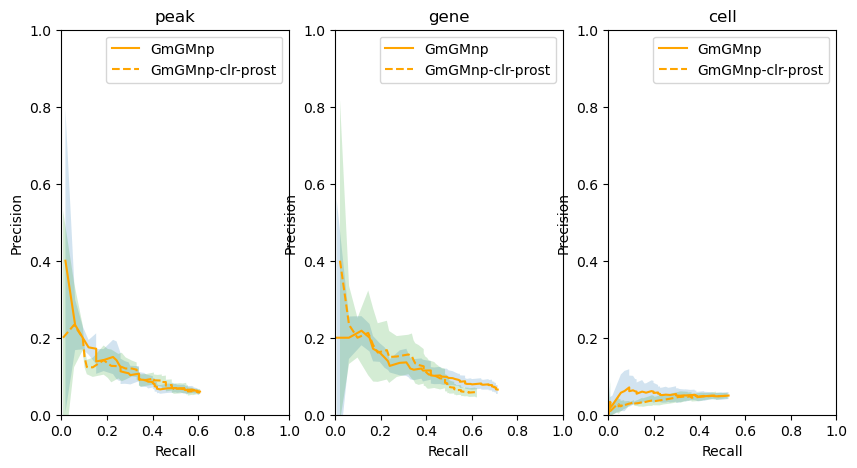

In [18]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
        "GmGMnp-clr-prost": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", centering_method="clr-prost", use_nonparanormal_skeptic=True),
    },
    Lambdas={
        "GmGMnp": np.linspace(0.001, 0.2, 50),
        "GmGMnp-clr-prost": np.linspace(0.001, 0.2, 50),
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGMnp": "orange",
        "GmGMnp-clr-prost": "orange",
    },
    linestyle={
        "GmGMnp": "-",
        "GmGMnp-clr-prost": "--",
    }
)
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


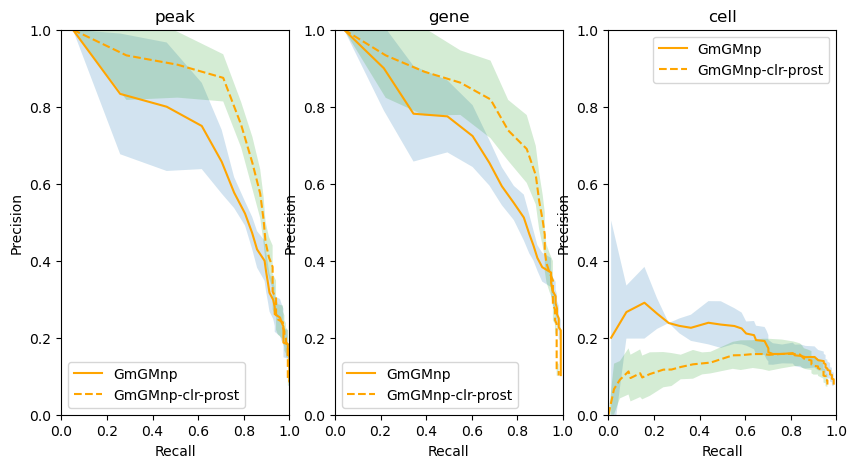

In [19]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
        "GmGMnp-clr-prost": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", centering_method="clr-prost", use_nonparanormal_skeptic=True),
    },
    Lambdas={
        "GmGMnp": np.linspace(0.001, 0.2, 50),
        "GmGMnp-clr-prost": np.linspace(0.001, 0.2, 50),
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGMnp": "orange",
        "GmGMnp-clr-prost": "orange",
    },
    linestyle={
        "GmGMnp": "-",
        "GmGMnp-clr-prost": "--",
    }
)
pass

# Further Tests

## Lopsided

In [20]:
from GmGM.synthetic import ZiLNDistribution
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.05),
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.05),
        ),
    },
    size={
        "cell": 200,
        "gene": 50,
        "peak": 50
    },
    distribution=ZiLNDistribution(np.random.uniform(size=(50)).reshape(1, 50))
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 200
	gene: 50
	peak: 50
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.05)>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.05)>
axis_join=
	Kronecker Sum
distribution=
	rna: <ZiLN Distribution, truncation=[[0.97757752 0.6932088  0.27886451 0.51268465 0.92529458 0.61364883
  0.35504067 0.65482788 0.60454483 0.18513997 0.80972574 0.53856631
  0.80877458 0.26791109 0.91815947 0.032529   0.81926753 0.11381236
  0.34621635 0.12252239 0.4009967  0.02597693 0.30327932 0.04255949
  0.42439844 0.20528205 0.19728922 0.50492719 0.75927946 0.60417096
  0.50099589 0.31333397 0.19253947 0.07423781 0.25138455 0.52517853
  0.61186808 0.78628759 0.12714281 0.68993044 0.19146618 0.82350322
  0.46669833 0.62143875 0.622

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


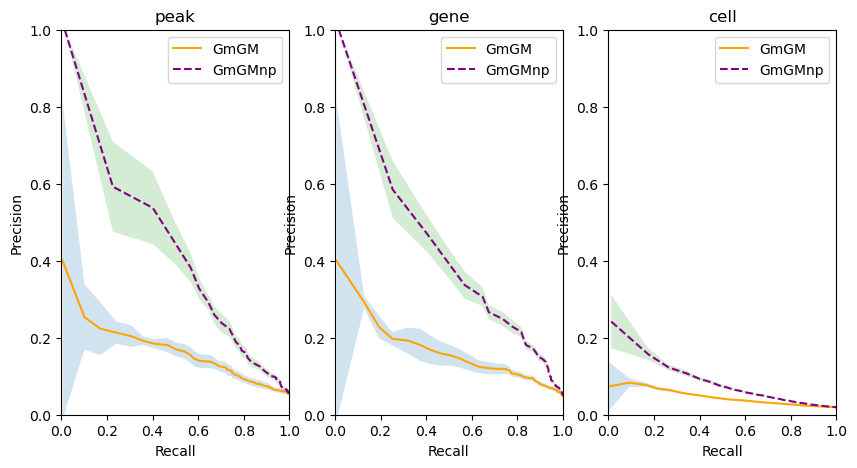

In [21]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 1, 50),
        "GmGMnp": np.linspace(0.001, 1, 50),
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGMnp": "purple",
    },
    linestyle={
        "GmGM": "-",
        "GmGMnp": "--",
    }
)
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


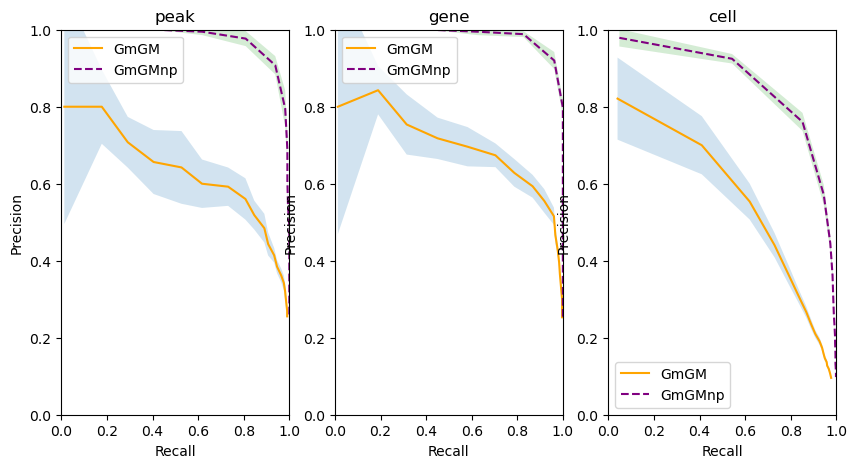

In [22]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 20),
        "GmGMnp": np.linspace(0.001, 0.2, 20),
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGMnp": "purple",
    },
    linestyle={
        "GmGM": "-",
        "GmGMnp": "--",
    }
)
pass

## n_comps 

In [2]:
from GmGM.synthetic import ZiLNDistribution
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "cell": 50,
        "gene": 50,
        "peak": 50
    },
    distribution=ZiLNDistribution(np.random.uniform(size=(50)).reshape(1, 50))
)
n_comps = 25
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 50
	gene: 50
	peak: 50
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
axis_join=
	Kronecker Sum
distribution=
	rna: <ZiLN Distribution, truncation=[[0.43471866 0.70540077 0.51915817 0.81420446 0.7526871  0.47175886
  0.54093687 0.87385985 0.15866683 0.21301903 0.59253225 0.06309967
  0.0424759  0.36390679 0.51708105 0.12268208 0.05638679 0.48172412
  0.5070123  0.16042763 0.43559858 0.64733986 0.77254339 0.7364562
  0.28902287 0.1976605  0.86587628 0.95219234 0.31571534 0.41234732
  0.4012683  0.33151209 0.19976099 0.7643404  0.58989321 0.24880546
  0.23845496 0.35360141 0.24024655 0.24931546 0.07080158 0.25365396
  0.67535247 0.01080393 0.61933

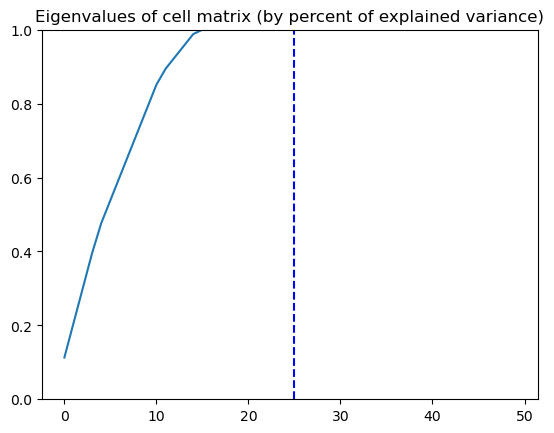

In [3]:
generator.reroll_Psis()

eigs = np.linalg.eigh(generator.Psis["cell"])[0][::-1]
eigs[eigs <= 1e-6] = 0
#eigs[eigs != 0] = 1/eigs[eigs!=0]
plt.plot((eigs/eigs.sum()).cumsum())
plt.ylim(0, 1)
_n_comps = generator.generator["cell"].n_comps
if _n_comps is not None:
    plt.axvline(_n_comps, color="red")
plt.axvline(n_comps, color="blue", linestyle="--")
plt.title("Eigenvalues of cell matrix (by percent of explained variance)")
pass

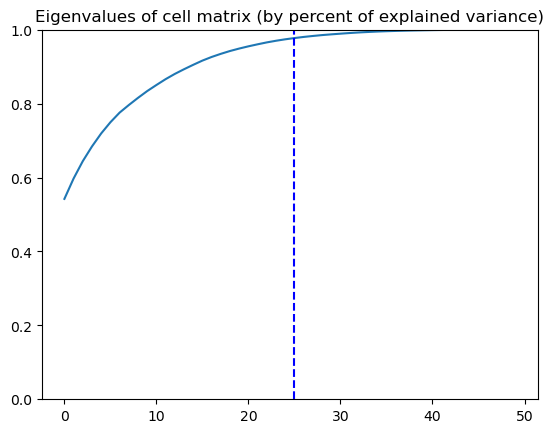

In [4]:
ds = generator.generate(num_samples=1).dataset["rna"].mean(axis=0)
eigs = np.linalg.eigh(ds @ ds.T)[0][::-1]
eigs[eigs < 1e-12] = 1e-12
plt.plot((eigs/eigs.sum()).cumsum())
plt.ylim(0, 1)
_n_comps = generator.generator["cell"].n_comps
if _n_comps is not None:
    plt.axvline(_n_comps, color="red")
plt.axvline(n_comps, color="blue", linestyle="--")
plt.title("Eigenvalues of cell matrix (by percent of explained variance)")
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


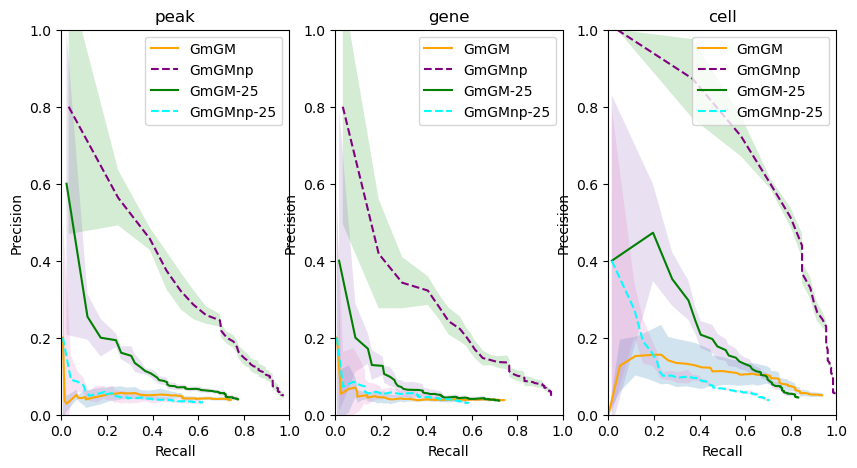

In [5]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
        f"GmGM-{n_comps}": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=n_comps),
        f"GmGMnp-{n_comps}": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True, n_comps=n_comps, nonparanormal_evec_backend="COCA"),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.4, 50),
        "GmGMnp": np.linspace(0.001, 0.4, 50),
        f"GmGM-{n_comps}": np.linspace(0.001, 0.4, 50),
        f"GmGMnp-{n_comps}": np.linspace(0.001, 0.4, 50),
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGMnp": "purple",
        f"GmGM-{n_comps}": "green",
        f"GmGMnp-{n_comps}": "cyan",
    },
    linestyle={
        "GmGM": "-",
        "GmGMnp": "--",
        f"GmGM-{n_comps}": "-",
        f"GmGMnp-{n_comps}": "--",
    }
)
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


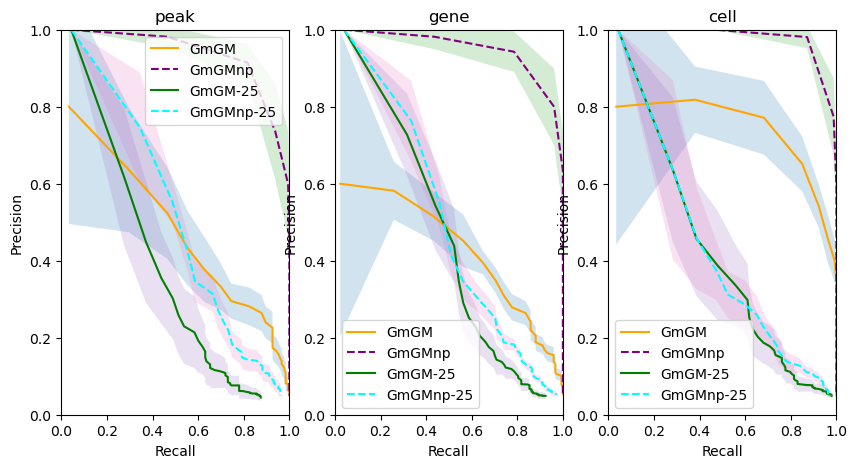

In [6]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
        f"GmGM-{n_comps}": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=n_comps),
        f"GmGMnp-{n_comps}": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True, n_comps=n_comps, nonparanormal_evec_backend="COCA"),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.4, 50),
        "GmGMnp": np.linspace(0.001, 0.4, 50),
        f"GmGM-{n_comps}": np.linspace(0.001, 0.4, 50),
        f"GmGMnp-{n_comps}": np.linspace(0.001, 0.4, 50),
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGMnp": "purple",
        f"GmGM-{n_comps}": "green",
        f"GmGMnp-{n_comps}": "cyan",
    },
    linestyle={
        "GmGM": "-",
        "GmGMnp": "--",
        f"GmGM-{n_comps}": "-",
        f"GmGMnp-{n_comps}": "--",
    }
)
pass

In [8]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGMnp": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True),
        f"GmGM-{50}": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=50),
        f"GmGMnp-{50}": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", use_nonparanormal_skeptic=True, n_comps=50, nonparanormal_evec_backend="COCA"),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.4, 50),
        "GmGMnp": np.linspace(0.001, 0.4, 50),
        f"GmGM-{50}": np.linspace(0.001, 0.4, 50),
        f"GmGMnp-{50}": np.linspace(0.001, 0.4, 50),
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(
    results,
    figsize=(10, 5),
    color={
        "GmGM": "orange",
        "GmGMnp": "purple",
        f"GmGM-{50}": "green",
        f"GmGMnp-{50}": "cyan",
    },
    linestyle={
        "GmGM": "-",
        "GmGMnp": "--",
        f"GmGM-{50}": "-",
        f"GmGMnp-{50}": "--",
    }
)
pass

Attempt 1/5
